In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import time
import math
import pickle

In [3]:
filename_Xtrain = '../data/X_train.csv'
filename_ytrain = '../data/y_train.csv'
filename_Xtest = '../data/X_test.csv'
filename_ytest = '../data/y_test.csv'

# Set Pandas to show all the columns
pd.set_option('display.max_columns', None)

# Read the data as a dataframe
X_train = pd.read_csv(filename_Xtrain)
y_train = pd.read_csv(filename_ytrain)

X_test = pd.read_csv(filename_Xtest)
y_test = pd.read_csv(filename_ytest)

In [4]:
y_train = y_train.iloc[:,0]
y_test = y_test.iloc[:,0]

### Decision of parameters

In this case we will use GridSearch to select the value of the hyperparameter C. 
<br> This parameters is in charge of the regularization (the strength of the regularization is inversely proportional to this value).
<br> The input range of values to select for C is a logarithmic scale in base 3 and 21 values

After looking at the hyperparameters and their default values, we decided to change dual to False. 
<br> This parameters tells the algorithm to either solve the dual or primal optimization problem and for n_samples>n_features it is recomended the primal, so dual=False

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix

In [6]:
from sklearn.svm import LinearSVC

In [7]:
startTime = time.time()

vectorC = np.logspace(-3, 3, 21)

param_grid = {'C': vectorC}

grid = GridSearchCV(LinearSVC(dual = False), 
                    scoring='accuracy', 
                    param_grid=param_grid, cv=5, verbose=1)
grid.fit(X_train, y_train)

endTime = time.time()
print(f"time of training: {(endTime - startTime)/60} minutes")

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))



Fitting 5 folds for each of 21 candidates, totalling 105 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  2.5min finished


time of training: 2.5488786657651263 minutes
best mean cross-validation score: 0.608
best parameters: {'C': 0.03162277660168379}


This parameter C can also be explained as a mesure of sensitivity (recall -- fraction of the total amount of classified as popular articles that were actually popular) 
</font>
This value has been set to a low value as expected because the range in which the data is moving for some features can be large and this C will control that the model doesn't overfit with those. 

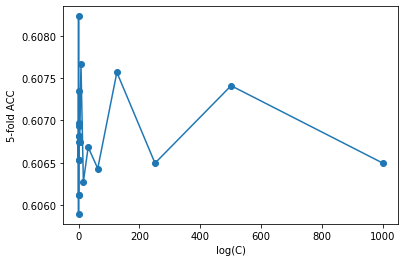

In [8]:
scores = np.array(grid.cv_results_['mean_test_score'])

plt.plot(vectorC,scores,'-o')
plt.xlabel('log(C)')
plt.ylabel('5-fold ACC')

plt.show()

### Train with the best parameters

In [9]:
Copt = grid.best_params_['C']
svmModel = LinearSVC(dual  = False, C = Copt)
svmModel.fit(X_train,y_train)

print("Train: ",svmModel.score(X_train,y_train))
print("Test: ",svmModel.score(X_test,y_test))

Train:  0.6077565820589627
Test:  0.6051204439399672


### Save the model

In [10]:
filename = '../models/LinearSVC.sav'
pickle.dump(svmModel, open(filename, 'wb'))

### Load model

In [11]:
# load the model from disk
filename = '../models/LinearSVC.sav'
svmModel = pickle.load(open(filename, 'rb'))
result = svmModel.score(X_test, y_test)
print(result)

0.6051204439399672


### Evaluate the model


--> The classification report is: 
               precision    recall  f1-score   support

         0.0       0.58      0.52      0.55      3684
         1.0       0.62      0.68      0.65      4245

    accuracy                           0.61      7929
   macro avg       0.60      0.60      0.60      7929
weighted avg       0.60      0.61      0.60      7929



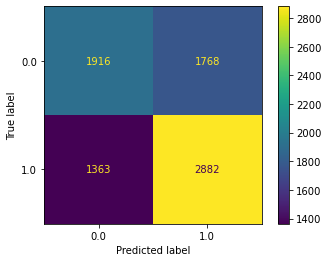

In [12]:
predictionsSVM = svmModel.predict(X_test)
print("\n--> The classification report is: \n", classification_report(y_test, predictionsSVM))
plot_confusion_matrix(svmModel, X_test, y_test)

In this case we see that the recall is quite acceptable, eventhough the accuracy is not that good

In this case we have had to use LinearSVC instead of using SVC with kernel = rbf that tends to work a bit better. However, this last one is not recommended to be used with large amount of data because it lasts many hours at some cases (as it was ours) so it turns to be not optimal.

The reason for which LinearSVC performs quicker than SVC is that it is implemented with "liblinear" instead of with "libsvm" and this allows more flexibility in the assignment of weights and in adjusting the cost function.

The problem of using this model is that we cannot get the predict_proba and, therefore, we can not compute the roc_curve and neither the AUC. Moreover, this will give problems in the "embedding" notebook when implementing the Voting Classifier; but it will be further explained there.